# Wide and deep model for input classification

## Data analysis

### Download data

In [51]:
from six.moves import urllib

train_data_path = "/tmp/workspace/wide_and_deep_model/adult.data"
urllib.request.urlretrieve("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data", train_data_path)

test_data_path = "/tmp/workspace/wide_and_deep_model/adult.test"
urllib.request.urlretrieve("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.test", test_data_path)

('/tmp/workspace/wide_and_deep_model/adult.test',
 <httplib.HTTPMessage instance at 0x12ce6f368>)

### Define columns of the data

In [52]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "gender",
  "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]
LABEL_COLUMN = 'label'
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
CONTINUOUS_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]

### Data visulization

In [53]:
import pandas as pd

df_train = pd.read_csv(train_data_path, names=COLUMNS, skipinitialspace=True)
df_test = pd.read_csv(test_data_path, names=COLUMNS, skipinitialspace=True, skiprows = 1)



In [54]:
# convert income bracket to int
df_train[LABEL_COLUMN] = (df_train['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
df_test[LABEL_COLUMN] = (df_test['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)

In [55]:
df_train

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K,1


### For continuous input

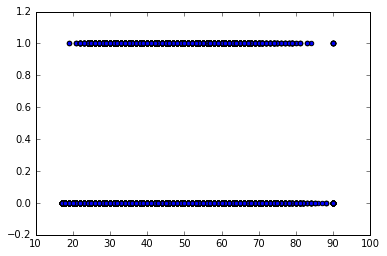

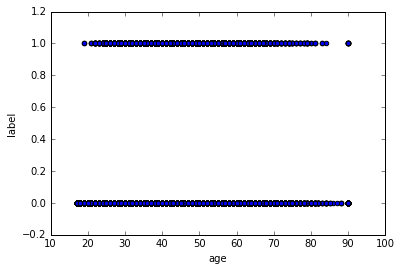

In [56]:
# scatter for continuous input

# plot with matplotlib directly
import matplotlib.pylab as plt
# enable pylab mode in ipython notebook as pylab has been deprecated
%matplotlib inline
plt.scatter(df_train.age, df_train.label)

# plot with pandas API, which referes to matplotlib
df_train.plot(kind='scatter', x='age', y='label')

### For categorical column

In [57]:
# Get unique value of categorical column
df_train.education.unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

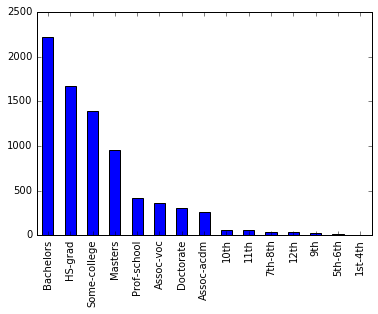

In [58]:
# Plot value count on one column
df_train[df_train.label == 1].education.value_counts().plot(kind='bar')

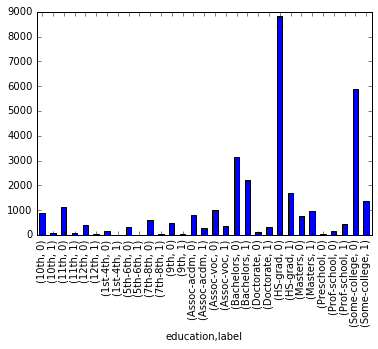

In [59]:
# group by two columns and count number of records in each 
edu_labl_col_name = ['education', 'label']
df_train.groupby(edu_labl_col_name).size().plot(kind='bar')

## Linear model

### Converting data to Tensors

In [60]:
import tensorflow as tf

def input_fn(df):
    # Create a dictionary mapping from each continuous feature column name (k)
    # to the values of that column stored in a constant Tensor
    continuous_cols = {k : tf.constant(df[k].values) for k in CONTINUOUS_COLUMNS}
    
    # Creates a dictionary mapping from each categorical feature column name(k)
    # to the values of that column stored in a tf.SparseTensor
    categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(df[k].size)],
      values=df[k].values,
      dense_shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
    
    # Merge the two dictionaries into one
    feature_cols = dict(continuous_cols.items() + categorical_cols.items())
    
    # Converts the label columns into a constant Tensor
    label = tf.constant(df[LABEL_COLUMN].values)
    
    # Return the feature columns and the label
    return feature_cols, label

def train_input_fn():
    return input_fn(df_train)

def eval_input_fn():
    return input_fn(df_test)

## Selecting and Engineering Features for the Model

A feature column can be:
* Raw columns in the original dataframe: base feature columns
* Derived feature columns through transformation: derived feature columns


### Base Categorical Feature Columns

SparseColumn:
* Will assign an integer ID to each category
* You can choose to proide the category list with: sparse_column_with_keys()
* Or let TensorFlor hash the values into it integer ID by providing a hash_bucket_size

In [61]:
# Provide keys for sparse column wiht keys
gender = tf.contrib.layers.sparse_column_with_keys(column_name="gender", keys=["Female", "Male"])

# Hash category into different ID
marital_status = tf.contrib.layers.sparse_column_with_hash_bucket("marital_status", hash_bucket_size=10)
race = tf.contrib.layers.sparse_column_with_hash_bucket("race", hash_bucket_size=100)
education = tf.contrib.layers.sparse_column_with_hash_bucket("education", hash_bucket_size=1000)
relationship = tf.contrib.layers.sparse_column_with_hash_bucket("relationship", hash_bucket_size=100)
workclass = tf.contrib.layers.sparse_column_with_hash_bucket("workclass", hash_bucket_size=100)
occupation = tf.contrib.layers.sparse_column_with_hash_bucket("occupation", hash_bucket_size=1000)
native_country = tf.contrib.layers.sparse_column_with_hash_bucket("native_country", hash_bucket_size=1000)


### Base Continuous Feature Columns

Define a RealValuedColumn for each continuous feature column

In [62]:
age = tf.contrib.layers.real_valued_column("age")
education_num = tf.contrib.layers.real_valued_column("education_num")
capital_gain = tf.contrib.layers.real_valued_column("capital_gain")
capital_loss = tf.contrib.layers.real_valued_column("capital_loss")
hours_per_week = tf.contrib.layers.real_valued_column("hours_per_week")

age.key

"_RealValuedColumn(column_name=age, dimension=1, default_value=None, dtype=<dtype: 'float32'>)"

### Discretization Continuous Features
For feature like age, we know that a person's income may grow with age in the early stage of one's career, then growth may slow at some point, and finally the income decreases after retirement. 
Using 'age' as a real-valued features might not be a good choice, as the linearly model can only learn one of these cases:
* Positive correlation
* Negative correlation
* no correlation

One solution is to bucketize the continuous value: dividing the entire range of a continuous feature into a set of consecutive bins/buckets, and then converting the original numerical feature into a bucket ID.

In [63]:
# The 10 boundaries divide the ages into 11 age groups.
age_buckets = tf.contrib.layers.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

### Cross Features

The base features might not be enouogh to explain the data. Say we only have one weight for  education="Bachelors" and education="Masters", we won't be able to capture every single education-occupation combination, say how do you distinguish between:
* education="Bachelors" AND occupation="Exec-managerial"
* education="Bachelors" AND occupation="Craft-repair"

Single weight makes the above feature equals to:
* occupation="Exec-managerial"
* occupation="Craft-repair"


The way to solve this problem is to use: crossed feature columns.

In [64]:
# Two feature cross
education_x_occupation = tf.contrib.layers.crossed_column([education, occupation], hash_bucket_size=int(1e4))

# Three features cross
age_buckets_x_education_x_occupation = tf.contrib.layers.crossed_column([age_buckets, education, occupation], hash_bucket_size=int(1e6))

In [65]:
education_x_occupation.key

"_CrossedColumn(columns=(_SparseColumn(column_name='education', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumn(column_name='occupation', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string)), hash_bucket_size=10000, hash_key=None, combiner='sum', ckpt_to_load_from=None, tensor_name_in_ckpt=None)"

## Logistic Regression Model

input columns:
* SparseColumn
* RealValuedColumn
* BuckedizedColumn
* CrossedColumn

In [76]:
model_dir = "/tmp/workspace/wide_model_train/"
wide_columns = [gender, native_country, education, occupation, workclass, marital_status, race,
  age_buckets, education_x_occupation, age_buckets_x_education_x_occupation]
m = tf.contrib.learn.LinearClassifier(feature_columns=wide_columns,
  model_dir=model_dir)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x122d70810>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


## Train and Evaluating the Model

In [67]:
m.fit(input_fn=train_input_fn, steps=200)


Instructions for updating:
The default behavior of sparse_feature_cross is changing, the default
value for hash_key will change to SPARSE_FEATURE_CROSS_DEFAULT_HASH_KEY.
From that point on sparse_feature_cross will always use FingerprintCat64
to concatenate the feature fingerprints. And the underlying
_sparse_feature_cross_op.sparse_feature_cross operation will be marked
as deprecated.
Instructions for updating:
The default behavior of sparse_feature_cross is changing, the default
value for hash_key will change to SPARSE_FEATURE_CROSS_DEFAULT_HASH_KEY.
From that point on sparse_feature_cross will always use FingerprintCat64
to concatenate the feature fingerprints. And the underlying
_sparse_feature_cross_op.sparse_feature_cross operation will be marked
as deprecated.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope 

LinearClassifier(params={'gradient_clip_norm': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x11be73ed0>, 'joint_weights': False, 'optimizer': None, 'feature_columns': [_SparseColumn(column_name='gender', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('Female', 'Male'), num_oov_buckets=0, vocab_size=2, default_value=-1), combiner='sum', dtype=tf.string), _SparseColumn(column_name='native_country', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumn(column_name='education', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumn(column_name='occupation', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumn(column_name='workclass', is_integerized=False, bucket_size=100, lookup_config=None, combiner='sum', dtype=tf.stri

In [68]:
# Evaluate the mode
results = m.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print "%s: %s" % (key, results[key])
# accuracy is important

Instructions for updating:
The default behavior of sparse_feature_cross is changing, the default
value for hash_key will change to SPARSE_FEATURE_CROSS_DEFAULT_HASH_KEY.
From that point on sparse_feature_cross will always use FingerprintCat64
to concatenate the feature fingerprints. And the underlying
_sparse_feature_cross_op.sparse_feature_cross operation will be marked
as deprecated.
Instructions for updating:
The default behavior of sparse_feature_cross is changing, the default
value for hash_key will change to SPARSE_FEATURE_CROSS_DEFAULT_HASH_KEY.
From that point on sparse_feature_cross will always use FingerprintCat64
to concatenate the feature fingerprints. And the underlying
_sparse_feature_cross_op.sparse_feature_cross operation will be marked
as deprecated.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope 

### Adding Regularization to Prevent Overfitting

In [69]:
m = tf.contrib.learn.LinearClassifier(feature_columns=[
  gender, native_country, education, occupation, workclass, marital_status, race,
  age_buckets, education_x_occupation, age_buckets_x_education_x_occupation],
  optimizer=tf.train.FtrlOptimizer(
    learning_rate=0.1,
    l1_regularization_strength=1.0,
    l2_regularization_strength=1.0),
  model_dir=model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1292065d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [70]:
m.fit(input_fn=train_input_fn, steps=200)

# Evaluate the mode
results = m.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print "%s: %s" % (key, results[key])

Instructions for updating:
The default behavior of sparse_feature_cross is changing, the default
value for hash_key will change to SPARSE_FEATURE_CROSS_DEFAULT_HASH_KEY.
From that point on sparse_feature_cross will always use FingerprintCat64
to concatenate the feature fingerprints. And the underlying
_sparse_feature_cross_op.sparse_feature_cross operation will be marked
as deprecated.
Instructions for updating:
The default behavior of sparse_feature_cross is changing, the default
value for hash_key will change to SPARSE_FEATURE_CROSS_DEFAULT_HASH_KEY.
From that point on sparse_feature_cross will always use FingerprintCat64
to concatenate the feature fingerprints. And the underlying
_sparse_feature_cross_op.sparse_feature_cross operation will be marked
as deprecated.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope 

# Deep Model

## Neural Network with Embeddings

A feed-forward neural network. Each of the sparse, high-dimensional categorical features are first converted into a low-dimensional and dense real-valued vector, often referred to as an embedding vector. 

The embedding vector are then concatenated with the continuous features, and then fed into the hidden layers of neural netowkr in the forward pass.

In [71]:
# Create deep columns
deep_columns = [
  tf.contrib.layers.embedding_column(workclass, dimension=8),
  tf.contrib.layers.embedding_column(education, dimension=8),
  tf.contrib.layers.embedding_column(gender, dimension=8),
  tf.contrib.layers.embedding_column(relationship, dimension=8),
  tf.contrib.layers.embedding_column(native_country, dimension=8),
  tf.contrib.layers.embedding_column(occupation, dimension=8),
  age, education_num, capital_gain, capital_loss, hours_per_week]


In [72]:
# Create model for neural network
deep_model_dir = "/tmp/workspace/deep_model_train/"
deep_model = tf.contrib.learn.DNNClassifier(model_dir=deep_model_dir,
                                    feature_columns=deep_columns,
                                    hidden_units=[100, 50])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13413cf50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [73]:
deep_model.fit(input_fn=train_input_fn, steps=200)

# Evaluate the mode
deep_model_results = deep_model.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(deep_model_results):
    print "%s: %s" % (key, deep_model_results[key])

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 201 into /tmp/workspace/deep_model_dir/model.ckpt.
INFO:tensorflow:loss = 0.501267, step = 201
INFO:tensorflow:global_step/sec: 6.22435
INFO:tensorflow:loss = 0.477296, step = 301
INFO:tensorflow:Saving checkpoints for 400 into /tmp/workspace/deep_model_dir/model.ckpt.
INFO:tensorflow:Loss for final step: 0.439156.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or li

## Wide and deep model

In [83]:
wide_and_deep_model_dir = "/tmp/workspace/wide_deep_model_train/"

wide_and_deep_model = tf.contrib.learn.DNNLinearCombinedClassifier(
        model_dir=wide_and_deep_model_dir,
        linear_feature_columns=wide_columns,
        dnn_feature_columns=deep_columns,
        dnn_hidden_units=[100, 50])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11aa52d90>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [84]:
wide_and_deep_model.fit(input_fn=train_input_fn, steps=200)

# Evaluate the mode
wide_deep_model_results = wide_and_deep_model.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(wide_deep_model_results):
    print "%s: %s" % (key, wide_deep_model_results[key])

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histog